<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [8]</a>'.</span>

In [1]:
# Parameters
simulation_seed = 111539741
starting_risks = []
use_random_risk_layout = True


# Main simiulation

In [2]:
import pathlib

import jupedsim as jps
import pedpy
from matplotlib.patches import Circle
from shapely import Polygon
from jupedsim.internal.notebook_utils import read_sqlite_file
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "notebook"

%matplotlib inline

from Py.classes.riskSimulationValues import RiskSimulationValues
from Py.animation import animate
from Py.classes.simulation_config import SimulationConfig
from Py.classes.agentGroup import AgentGroup
from Py.pathFinding.settingPaths import *
from Py.database.agent_area_db_manager import *
import polygons.environment as pol
from Py.journey_configuration import set_journeys
from Py.simulation_manager import set_agents_in_simulation, run_agent_simulation
from Py.database.danger_sim_db_manager import get_risks_grouped_by_frame, create_risk_table, get_risk_levels_by_frame, read_risk_data
from Py.dangerSimulation.risk_simulation import simulate_risk
from Py.classes.Environment_info import Environment_info
from Py.database.group_path_db_manager import create_group_path_table

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

## Global Configuration

In [3]:
# -------------------------------
# Global Configuration
# -------------------------------

# Environment selection (uncomment the one you want)
# Environment = pol.get_simple_3x3()
# Environment = pol.get_comparing_algorithms_pol()
Environment = pol.get_cruise_ship()
# Environment = pol.get_mall()

# Environment metadata
Environment_name       = Environment.name
complete_area          = Environment.complete_area
obstacles              = Environment.obstacles
# sources                = Environment.sources # uncomment for example case
sources                = ["82"] # comment for example case
# targets                = Environment.targets # uncomment for example case
targets                = ["163", "164"] # comment for example case
pol.set_targets(targets, Environment)
waypoints              = Environment.waypoints
walkable_area          = Environment.walkable_area
G                      = Environment.graph
specific_areas         = Environment.specific_areas

# Simulation scenarios
modes = [0, 1, 2, 3]                 # other cases
# modes                  = [0, 1]        # case 3
total_agents           = 5             # agents per source

# Risk layout configuration
use_random_risk_layout = True          # False → default risk, True → random risk
risk_seed              = 4321           # seed for random risk generation
risk_iterations        = 7000          # Total number of simulation frames (default is 3000).
risk_increase_chance   = 0.05          # Probability of an individual risk increase per frame.
starting_risks = [("8", 1.0), ("57", 1.0), ("63", 1.0), ("64", 1.0), ("69", 1.0)]
# risk_overrides = [(2400, "153", 0.6), (2400, "225", 1.0), (2400, "224", 1.0), (2400, "201", 0.6)] # case 3

# Path-finding & speed parameters
risk_threshold         = 0.5           # threshold for avoiding high-risk areas
gamma                  = 0.2           # parameter for alternative path computation
stairs_max_speed       = 0.6           # max speed on stairs
normal_max_speed       = 1.2           # max speed on flat

# Group settings (parallel arrays indexed by mode)
modes_names = ["Low_awareness_efficient_paths", "High_awareness_efficient_paths", "Low_awareness_centrality_path", "High_awareness_centrality_path"]      # other cases
# modes_names                = ["Low_awareness", "High_awareness"]  # case 3
awareness_levels_per_group = [0, 1, 0, 1]
algorithm_per_group        = [0, 0, 1, 1]

# Frame intervals
every_nth_frame_simulation = 3          # simulation iterations per frame
every_nth_frame_animation  = 50         # frames per risk update

# Risk simulation database files
risk_db_variants = {
    'default':    f"../../sqlite_data/default_{Environment_name}_risks.db",
    'random':     f"../../sqlite_data/{Environment_name}_risks.db",
    'node_8':     f"../../sqlite_data/{Environment_name}_risks_node_8_5_p.db",
    'node_set':   f"../../sqlite_data/{Environment_name}_risks_node_8,57,63,64,69_5_p.db",
}

variant_key = 'random' if use_random_risk_layout else 'node_8'

connection_file = risk_db_variants[variant_key]
simulation_seed = risk_seed if use_random_risk_layout else None

# Paths and database connections
paths_file          = f"../../sqlite_data/{Environment_name}_paths.db"
group_path_file     = f"../../sqlite_data/{Environment_name}_group_paths_data.db"
trajectory_files    = {}
agent_groups_per_mode = {}
agent_area_files      = {}

# Open connections (use later in your notebook)
risk_db_conn        = sqlite3.connect(connection_file)
paths_conn          = sqlite3.connect(paths_file)
# create_paths_table(paths_conn) # uncomment to restart the paths connections db
group_path_conn     = sqlite3.connect(group_path_file)


## Environment

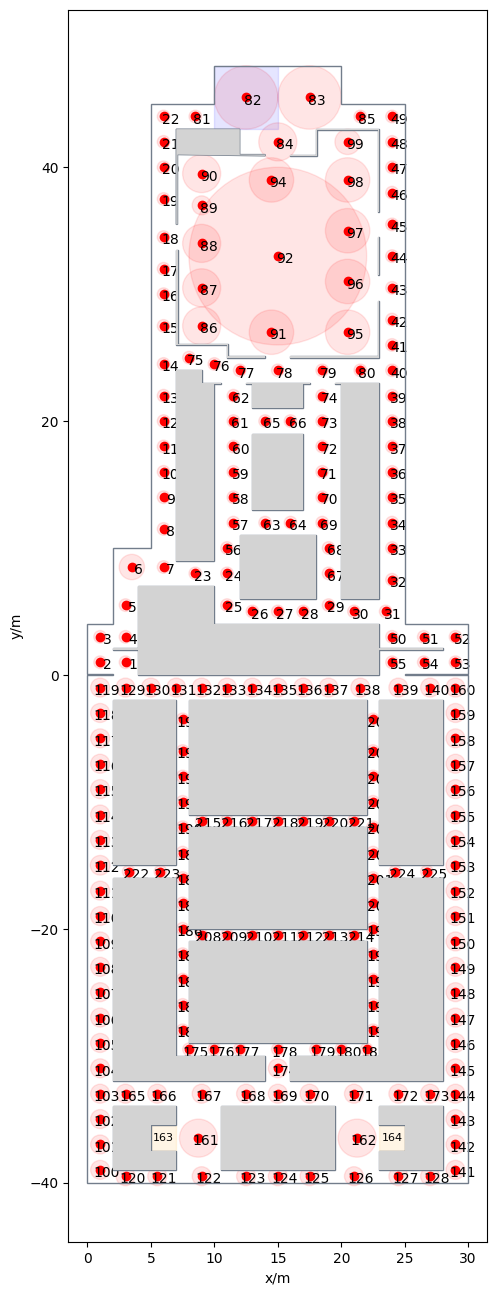

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 16))
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(5, -5),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)
for area_id in targets:
    x, y = Polygon(specific_areas[area_id]).exterior.xy
    plt.fill(x, y, alpha=0.1, color="orange")
    centroid = Polygon(specific_areas[area_id]).centroid
    plt.text(centroid.x, centroid.y, f"{area_id}", ha="center", va="center", fontsize=8)

for area_id in sources:
    x, y = specific_areas[area_id].exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")

plt.savefig('../img/cruise_ship_layout.png', dpi=300)

## Configuration of Simulation Scenarios

In [5]:
# Dictionary to store simulations for different percentages of agents
simulations = {}

# Loop over each percentage value to create a corresponding simulation
for mode in modes:
    # Define the output file path for storing the simulation trajectories
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"

    # Create a new simulation instance using JPS (JuPedSim)
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(  # Define the agent movement model
            strength_neighbor_repulsion=2.6,  # Strength of repulsion between neighboring agents
            range_neighbor_repulsion=0.1,  # Distance at which agents start repelling each other
            range_geometry_repulsion=0.05,  # Distance at which agents start avoiding obstacles
        ),
        geometry=walkable_area.polygon,  # Define the walkable area for the simulation
        trajectory_writer=jps.SqliteTrajectoryWriter(  # Specify where to store simulation results
            output_file=pathlib.Path(trajectory_file),  # Save output to the specified SQLite file
            every_nth_frame=every_nth_frame_simulation

        ),

    )

    # Store the simulation object in the dictionary using the percentage as a key
    simulations[mode] = simulation

## Journey configuration

In [6]:
# In journey_configuration.py

## Allocate Agents

In [7]:
positions = dict()
for source in sources:
    positions[source] = jps.distribute_by_number(
        polygon=specific_areas[source],
        number_of_agents=total_agents,
        distance_to_agents=0.4,
        distance_to_polygon=0.5,
        seed=45131502,
    )

## Launching the Simulation

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [8]:
# Simulation parameters
riskSimulationValues = RiskSimulationValues(risk_iterations, risk_increase_chance, risk_threshold, starting_risks, risk_overrides)
try:
    if use_random_risk_layout:
        # Create or reset the risk table if random risk layout is enabled
        create_risk_table(risk_db_conn)

        # Simulate risk propagation and store results in the database
        simulate_risk(riskSimulationValues, every_nth_frame_animation, G, targets, risk_db_conn, simulation_seed) # animation not every frame is shown in the animation
    # get first frame risk table
    risk_first_frame= get_risk_levels_by_frame(risk_db_conn, 0)
finally:
    # Ensure the database connection is closed after operations
    risk_db_conn.close()

NameError: name 'risk_overrides' is not defined

In [ ]:
create_group_path_table(group_path_conn)
EnvInf = Environment_info(G, paths_conn, floor_number=Environment.floor_number)
if Environment.floor_number > 1:
    EnvInf.floors = Environment.floors
    EnvInf.floor_connecting_nodes = Environment.floor_connecting_nodes


for mode, simulation in simulations.items():

    agent_area_files[mode] = f"../../sqlite_data/agent_area_{Environment_name}_mode_{mode}.db"
    agent_area_conn = sqlite3.connect(agent_area_files[mode])

    create_agent_area_table(agent_area_conn)

    exit_ids = {}
    for area_id in targets:
        exit_ids[area_id] = simulation.add_exit_stage(specific_areas[area_id])

    # Initialize a dictionary to store waypoint IDs
    waypoints_ids = {}
    # Convert waypoints into simulation waypoints with associated distances
    for node, (waypoint, distance) in waypoints.items():
        waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    agent_groups = dict()
    for i, source in enumerate(sources):

        agent_group_aux = AgentGroup(None, None, None, algorithm_per_group[mode], awareness_levels_per_group[mode]) # other cases
        # agent_group_aux = AgentGroup(None, None, None, i, mode)   # case 3
        path = compute_alternative_path(targets, agent_group_aux, EnvInf, source, risk_per_node=risk_first_frame, gamma=gamma)

        # Set up a journey for the simulation
        journeys_ids = set_journeys(
            simulation, source, [path], waypoints_ids, exit_ids
        )

        # Retrieve the best path for the first source and its associated journey ID
        journey_id, best_path_source = journeys_ids[source][0]
        next_node = best_path_source[1]  # Get the next node on the best path
        first_waypoint_id = waypoints_ids[next_node]  # Determine the waypoint ID for the next node

        agents = set_agents_in_simulation(simulation, positions[source], journey_id, first_waypoint_id, normal_max_speed)

        agent_group_aux.path = path

        # currently unnecessary
        agents_initial_nodes = {}
        for agent in agents:
            agents_initial_nodes[agent] = path[0]
        agent_group_aux.current_nodes = agents_initial_nodes

        agent_group_aux.agents = agents

        agent_groups[source] = agent_group_aux

    simulation_config = SimulationConfig(simulation, every_nth_frame_simulation, every_nth_frame_animation, waypoints_ids, exit_ids, gamma, normal_max_speed, stairs_max_speed)


    risk_db_conn = sqlite3.connect(connection_file)
    # Run the agent simulation, updating paths based on the risk levels
    run_agent_simulation(
        simulation_config,
        agent_groups,
        EnvInf,
        risk_db_conn,
        agent_area_conn,
        group_path_conn,
        threshold=risk_threshold,  # Threshold for avoiding high-risk areas
    )

    risk_db_conn.close()
    agent_area_conn.close()

    print(f"{mode} simulation finished")

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"
    trajectory_files[mode] = trajectory_file
    agent_groups_per_mode[mode] = agent_groups

paths_conn.close()
group_path_conn.close()

In [ ]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

## Visualizing Agent Pathways

In [ ]:
agent_trajectories = {}
for mode in modes:
    trajectory_file = trajectory_files[mode]
    agent_trajectories[mode], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[mode],
        walkable_area,
        title_note=f"Mode: {modes_names[mode]}",
        risk_per_frame=all_risks,
        specific_areas=specific_areas,
        every_nth_frame=every_nth_frame_animation
    ).show()

## Analysus if the results

In [ ]:
# show the hazzards of a specific frame
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks_frame_550 = get_risk_levels_by_frame(connection, 1300)

risky_areas = []
for area, risk in all_risks_frame_550.items():
    if risk > 0.0:
        risky_areas.append((area, risk))

# Retrieve the boundary coordinates of the complete_area polygon
minx, miny, maxx, maxy = complete_area.bounds

# Create a figure with subplots arranged in two rows and two columns
fig, axes = plt.subplots(
    nrows=2, #other cases
    # nrows=1,  # case 3
    ncols=2, figsize=(12, 16),
)

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Define a list of colors to differentiate agent groups in the plots
colors = ["red", "blue", "green"]

# Iterate over each subplot axis and its corresponding mode
for ax, mode in zip(axes, agent_groups_per_mode):
    # Extract trajectory data for the current mode
    trajectories = agent_trajectories[mode].data

    # Initialize a list to hold groups of agents for the current mode
    list_of_groups = []

    # Populate the list with agent groups from each source
    for source in sources:
        list_of_groups.append(agent_groups_per_mode[mode][source].agents)

    # Iterate over each group of agents
    for ig, group in enumerate(list_of_groups):
        # Create a TrajectoryData object for the current group
        traj = pedpy.TrajectoryData(
            trajectories[trajectories["id"].isin(group)],
            frame_rate=agent_trajectories[mode].frame_rate,
        )

        # Plot the trajectories of the current group on the current axis
        pedpy.plot_trajectories(
            traj=traj,
            walkable_area=walkable_area,
            axes=ax,
            traj_color=colors[ig],
            traj_width=0.5,
            traj_start_marker=".",
        )

    # Set the title of the subplot to indicate the current mode
    ax.set_title(f"Mode: {modes_names[mode]}")

    # Set the x and y axis limits based on the complete_area boundaries
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Ensure the aspect ratio is equal to maintain the scale of the plot
    ax.set_aspect('equal', adjustable='box')

    # Overlay exit polygons on the plot
    for area_id in targets:
        pol = Polygon(specific_areas[area_id])
        # Extract the x and y coordinates of the polygon's exterior
        x, y = pol.exterior.xy

        # Fill the polygon area with a semi-transparent red color
        ax.fill(x, y, alpha=0.1, color="red")

        # Outline the polygon with a white border
        ax.plot(x, y, color="white")

        # Calculate the centroid of the polygon
        centroid = pol.centroid

        # Place the name of the exit at the centroid position
        ax.text(
            centroid.x, centroid.y, area_id, ha="center", va="center", fontsize=10
        )


    for area, risk_value in risky_areas:
        if risk_value > 0.0:
            x, y = specific_areas[area].exterior.xy
            if risk_value < risk_threshold:
                ax.fill(x, y, alpha=0.5, color="pink")
            else:
                ax.fill(x, y, alpha=0.5, color="purple")


# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Set the final size of the figure if needed
fig.set_size_inches((10, 12))

# Display the figure with all subplots
#plt.show()
plt.savefig('../img/experiments', dpi=300)



In [ ]:
risk_frames = [1300, 2400]
trajectory_cuts = [(None, 2000), (2000, None)]

with sqlite3.connect(connection_file) as conn:
    for risk_frame, (f_start, f_end) in zip(risk_frames, trajectory_cuts):
        # 1) Obtener riesgos en el frame
        risks = get_risk_levels_by_frame(conn, risk_frame)
        risky_areas = [(area, r) for area, r in risks.items() if r > 0.0]

        # 2) Crear figura
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
        axes = axes.flatten()

        # 3) Para cada modo, plot de trayectorias
        for ax, mode in zip(axes, agent_trajectories.keys()):
            # DataFrame completo de este modo
            df_full = agent_trajectories[mode].data

            # Recortar por rango de frames
            df = df_full
            if f_start is not None:
                df = df[df["frame"] >= f_start]
            if f_end is not None:
                df = df[df["frame"] <= f_end]

            # Ahora, por cada grupo, filtrar y crear su TrajectoryData
            for color, source in zip(["red", "blue", "green"], sources):
                group_ids = agent_groups_per_mode[mode][source].agents
                df_group = df[df["id"].isin(group_ids)]
                traj_group = pedpy.TrajectoryData(df_group, frame_rate=agent_trajectories[mode].frame_rate)

                pedpy.plot_trajectories(
                    traj=traj_group,
                    walkable_area=walkable_area,
                    axes=ax,
                    traj_color=color,
                    traj_width=0.5,
                    traj_start_marker=".",
                )

            # Ajustes de estilo y límites
            ax.set_title(f"Modo: {modes_names[mode]}")
            minx, miny, maxx, maxy = complete_area.bounds
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_aspect("equal", adjustable="box")

            # Dibujar salidas
            for area_id in targets:
                poly = specific_areas[area_id]
                x, y = poly.exterior.xy
                ax.fill(x, y, alpha=0.1, color="red")
                ax.plot(x, y, color="white")
                c = poly.centroid
                ax.text(c.x, c.y, area_id, ha="center", va="center", fontsize=10)

            # Colorear zonas de riesgo
            for area, rv in risky_areas:
                poly = specific_areas[area]
                x, y = poly.exterior.xy
                color = "purple" if rv >= risk_threshold else "pink"
                ax.fill(x, y, alpha=0.5, color=color)

        plt.tight_layout()
        fig.set_size_inches((10, 12))
        # 4) Guardar la figura
        out_path = f"../img/experiment_risk_{risk_frame}.png"
        plt.savefig(out_path, dpi=600)
        print(f"Figura guardada en {out_path}")

## Calculate profiles

### Step 1: Compute individual speeds and Voronoi cells for each mode

In [ ]:
individual_speed_per_mode = dict()
individual_voronoi_cells_per_mode = dict()

# Loop over each mode in the list of modes
for mode in modes:
    # Compute individual speed for the current mode
    individual_speed = pedpy.compute_individual_speed(
        traj_data=agent_trajectories[mode],
        frame_step=5,
        speed_calculation=pedpy.SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    # Compute individual Voronoi polygons for the current mode
    individual_voronoi_cells = pedpy.compute_individual_voronoi_polygons(
        traj_data=agent_trajectories[mode],
        walkable_area=walkable_area,
        cut_off=pedpy.Cutoff(radius=0.8, quad_segments=3),
    )

    # Save the computed data into dictionaries keyed by mode
    individual_speed_per_mode[mode] = individual_speed
    individual_voronoi_cells_per_mode[mode] = individual_voronoi_cells

### Step 2: Compute density and speed profiles for each mode

In [ ]:
# Define the frame range for profile computation
min_frame_profiles = 600
max_frame_profiles = 700

# Initialize dictionaries to store density and speed profiles per mode
density_profiles_per_mode = dict()
speed_profiles_per_mode = dict()

# Loop over each mode to calculate the profiles
for mode in modes:
    # Filter the Voronoi data for frames within the desired range
    voronoi_filtered = individual_voronoi_cells_per_mode[mode][
        individual_voronoi_cells_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Filter the speed data for frames within the desired range
    speed_filtered = individual_speed_per_mode[mode][
        individual_speed_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Merge the filtered Voronoi and speed data on 'id' and 'frame'
    merged_data = pd.merge(
        voronoi_filtered,
        speed_filtered,
        on=["id", "frame"],
    )

    # Compute density and speed profiles using the merged data
    density_profiles, speed_profiles = pedpy.compute_profiles(
        individual_voronoi_speed_data=merged_data,
        walkable_area=walkable_area.polygon,
        grid_size=0.25,
        speed_method=pedpy.SpeedMethod.ARITHMETIC,
    )

    # Save the computed profiles in the corresponding dictionaries
    density_profiles_per_mode[mode] = density_profiles
    speed_profiles_per_mode[mode] = speed_profiles

### Step 3: Plot profiles with one row per mode and two columns per row
<div style="margin-left: 60px;"><h4>(first column: density, second column: speed)</h4></div>


In [ ]:
num_modes = len(modes)
fig, axes = plt.subplots(nrows=num_modes, ncols=2, figsize=(12, 4 * num_modes))

for idx, mode in enumerate(modes):
    # Seleccionamos el eje para densidad (columna 0) y para velocidad (columna 1)
    ax_density = axes[idx, 0]
    ax_speed = axes[idx, 1]

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=density_profiles_per_mode[mode],
        axes=ax_density,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=10,
        title=f"Density - {modes_names[mode]}",
    )

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=speed_profiles_per_mode[mode],
        axes=ax_speed,
        label="v / m/s",
        vmin=0,
        vmax=2,
        title=f"Speed - {modes_names[mode]}",
    )

fig.tight_layout(pad=2)
plt.show()

## Evacuation Times vs Mode

In [ ]:
evac_times = []
for mode, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate # time equals frame / frame rate
    evac_times.append(t_evac)

for mode in modes:
    print(f"Mode: {modes_names[mode]}, time: {evac_times[mode]:2f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

## Average agent in group time

In [ ]:
# Define the plotting colors in the same order as 'sources'
colors = ["red", "blue", "green"]

# Collect average evacuation times per group and mode, including the color
records = []
for mode, traj_obj in agent_trajectories.items():
    df = traj_obj.data
    fr = traj_obj.frame_rate
    for ig, source in enumerate(sources):
        group_ids = agent_groups_per_mode[mode][source].agents
        # Compute each agent's evacuation time = max frame / frame_rate
        per_agent_times = (
            df[df["id"].isin(group_ids)]
            .groupby("id")["frame"]
            .max()
            / fr
        )
        mean_time = per_agent_times.mean()
        records.append({
            "Mode": modes_names[mode],
            "Source (Group)": source,
            "Color": colors[ig],
            "Average Evacuation Time (s)": mean_time
        })

# Create DataFrame and print it
df_avg_times = pd.DataFrame(records)
print(df_avg_times.to_string(index=False))


## Risk vs Mode

In [ ]:
avg_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            avg_risk[mode] = get_average_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, average risk: {avg_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(avg_risk.values()),
        name="Average Risks"
    )
)

fig.update_layout(
    title="Average Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
risk_sum = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            risk_sum[mode] = calculate_average_agent_combined_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, total risk: {risk_sum[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(risk_sum.values()),
        name="Total Risks"
    )
)

fig.update_layout(
    title="Total Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
highest_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            highest_risk[mode] = get_max_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, highest risk: {highest_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(highest_risk.values()),
        name="Highest Risks"
    )
)

fig.update_layout(
    title="Highest Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
records = []

for mode in modes:
    # 1) Leer agent_area_data
    with sqlite3.connect(agent_area_files[mode]) as conn:
        df_aa = read_agent_area_data(conn)  # frame, agent_id, area, risk

    fr = agent_trajectories[mode].frame_rate

    # 2) Trajectory frames reales por agente
    traj_df = agent_trajectories[mode].data[['id', 'frame']]
    last_frames = traj_df.groupby('id')['frame'].max().to_dict()

    for source, group_obj in agent_groups_per_mode[mode].items():
        agents = group_obj.agents

        # 3) Construir timeline completo de cada agente
        full = traj_df[traj_df['id'].isin(agents)].copy()

        # 4) Mezclar con riesgo (puede haber NaN)
        full = full.merge(
            df_aa[['frame', 'agent_id', 'risk']],
            left_on=['id', 'frame'],
            right_on=['agent_id', 'frame'],
            how='left'
        ).drop(columns='agent_id')

        # 5) Rellenar el riesgo correctamente: backfill antes de ffill usando transform
        full.sort_values(['id', 'frame'], inplace=True)
        full['risk'] = (
            full
            .groupby('id')['risk']
            .transform(lambda s: s.bfill().ffill())
        )

        # 6) Detectar cambios de segmento de riesgo
        full['prev_risk'] = full.groupby('id')['risk'].shift()
        full['new_seg']   = (full['risk'] != full['prev_risk']).astype(int)
        full['seg_id']    = full.groupby('id')['new_seg'].cumsum()

        # 7) Último segmento por agente
        last_segs = full.groupby('id')['seg_id'].max().to_dict()

        # 8) Para cada segmento, calcular duración
        for (agent, seg), df_seg in full.groupby(['id', 'seg_id']):
            start = df_seg['frame'].iloc[0]

            if seg == last_segs[agent]:
                # último segmento: hasta el último frame real
                end = last_frames[agent]
            else:
                # no es último: inicio del siguiente segmento − 1
                next_start = full[
                    (full['id'] == agent) &
                    (full['seg_id'] == seg + 1)
                ]['frame'].iloc[0]
                end = next_start

            duration_s = (end - start) / fr

            records.append({
                'Mode':       modes_names[mode],
                'Group':      source,
                'Agent ID':   agent,
                'Risk Level': df_seg['risk'].iloc[0],
                'Time (s)':   duration_s
            })

# 9) Montar DataFrame de intervalos y sumar por agente y nivel de riesgo
df_intervals = pd.DataFrame(records)
df_totals = (
    df_intervals
    .groupby(['Mode','Group','Agent ID','Risk Level'], as_index=False)['Time (s)']
    .sum()
)
df_totals = df_totals[df_totals['Time (s)'] > 0].sort_values(['Agent ID','Risk Level'])
print("Time per Risk Level per Agent:")
print(df_totals.to_string(index=False))

# 10) Suma total de tiempo por agente
df_agent_sum = (
    df_totals
    .groupby(['Mode','Group','Agent ID'], as_index=False)['Time (s)']
    .sum()
    .rename(columns={'Time (s)': 'Total Time (s)'})
)
print("\nTotal Evacuation Time per Agent:")
print(df_agent_sum.to_string(index=False))

# 11) Estadística de tiempo máximo por modo
df_mode_stats = (
    df_agent_sum
    .groupby('Mode', as_index=False)['Total Time (s)']
    .max()
    .rename(columns={'Total Time (s)': 'Maximum_Time'})
)
print("\nMode Statistics (Min/Max):")
print(df_mode_stats.to_string(index=False))


In [ ]:
conn = sqlite3.connect(group_path_file)
df = pd.read_sql_query("SELECT * FROM group_path_data", conn)

df['next_path'] = df['next_path'].apply(json.loads)
df['path_length'] = df['next_path'].apply(len)

df_display = df[[
    'frame', 'group_id', 'algorithm', 'awareness',
    'current_area', 'path_length',
    'est_risk_mean', 'est_risk_max', 'est_risk_var',
    'risk_now'
]]

print("=== Group Path Data (primeras 20 filas) ===")
print(df_display.head(20).to_string(index=False))

summary = (
    df
    .groupby(['algorithm', 'awareness'])
    .agg(
        n_records=('frame', 'size'),
        mean_risk_mean=('est_risk_mean', 'mean'),
        max_risk_max=('est_risk_max', 'max'),
        mean_risk_var=('est_risk_var', 'mean'),
        avg_path_length=('path_length', 'mean')
    )
    .reset_index()
)

print("\n=== Resumen de estadísticas por algoritmo × awareness ===")
print(summary.to_string(index=False))

for (alg, aware), group_df in df.groupby(['algorithm', 'awareness']):
    plt.figure(figsize=(6,4))
    plt.plot(group_df['frame'], group_df['est_risk_mean'], marker='o')
    plt.title(f"Mean Estimated Risk over Time\n"
              f"Alg: {alg.capitalize()}  |  Awareness: {aware.capitalize()}")
    plt.xlabel("Frame")
    plt.ylabel("Mean Risk")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
